Assignment 2 For Clustering: Sessa Empirical Estimator
1. Read the Journals about the Sessa Empirical Estimator.
2. Convert the R codes into Python Codes (use jupyter notebook).
3. Using Simulated data (https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2019.00383/full) or a real world datasets of your choice (You can obtain it in Kaggle or in https://archive.ics.uci.edu/), perform the Sessa Empircal Estimator and generate some insights.
4. The Sessa Empirical Estimator uses K-Means clustering (again recall the disadvantages of K-Means), try to substitute a different clustering algorithm, generate a new insight using the new clustering algorithm.
5. Compare your results between Sessa Empirical Estimator using K-Means, and Sessa Empirical Estimator using the clustering algorithm of your choice.
6. Deadline is this Sunday, Feb 23, 2022 at 11:59 pm
7. Do this with your thesis partner.
8. You can use any A.I. assistant.
9. Create a callable function in each step. Check if these callable function has the same result (and insights) with your Jupyter Notebook.

In [ ]:
import pandas as pd

file_path = r"C:\Users\reigi\OneDrive\Desktop\School\CS 3203N\Assignment_2_Clustering\diabetes.csv"
df = pd.read_csv(file_path)

print(df.head())

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No


Adjusted Rand Index (K-Means): 0.000
Adjusted Rand Index (DBSCAN): 1.000


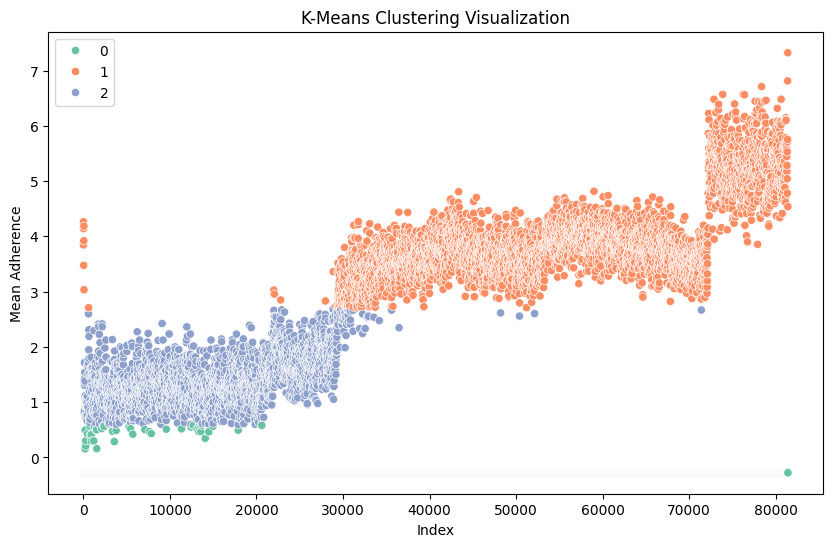


Insights for K-Means:
           count      mean       std       min       25%       50%       75%  \
Cluster                                                                        
0        74676.0 -0.275840  0.017450 -0.276245 -0.276245 -0.276244 -0.276244   
1         4294.0  3.973878  0.734358  2.709168  3.488039  3.804715  4.197823   
2         2450.0  1.442772  0.447625  0.594013  1.116229  1.389967  1.725365   

              max  
Cluster            
0        0.582574  
1        7.323027  
2        2.693369  

Insights for DBSCAN:
           count      mean       std       min       25%       50%       75%  \
Cluster                                                                        
-1           1.0  7.323027       NaN  7.323027  7.323027  7.323027  7.323027   
 0       81419.0 -0.000090  0.999683 -0.276245 -0.276245 -0.276244 -0.276244   

              max  
Cluster            
-1       7.323027  
 0       6.812828  


,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
-1,1.0,7.323027,NaN,7.323027,7.323027,7.323027,7.323027,7.323027
0,81419.0,-0.000090,0.999683,-0.276245,-0.276245,-0.276244,-0.276244,6.812828


In [41]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- Data Loading -------------------

def load_data(file_path):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  

    if "encounter_id" in df.columns:
        df.set_index("encounter_id", inplace=True)
    else:
        df["encounter_id"] = range(len(df))  

    return df

# ------------------- Simulated Data Generation -------------------

def simulate_adherence_data(n_samples=500, n_features=5):
    np.random.seed(42)
    
    data = np.random.rand(n_samples, n_features) * 100  
    columns = [f"Feature_{i+1}" for i in range(n_features)]
    
    true_labels = np.random.choice([0, 1, 2], size=n_samples)  
    df = pd.DataFrame(data, columns=columns)
    df["encounter_id"] = range(n_samples)  
    
    return df, true_labels

# ------------------- Sliding Window -------------------

def sliding_window(data, window_size=30, overlap=15):
    step = window_size - overlap
    windows = []

    for start in range(0, len(data), step):
        end = start + window_size
        window_data = data.iloc[start:end]  

        if not window_data.empty:
            mean_values = window_data.mean(numeric_only=True)  
            window_df = pd.DataFrame(mean_values).reset_index()
            window_df.columns = ["Feature", "Mean_Adherence"]
            window_df["Window"] = f"{start}-{end}"
            windows.append(window_df)

    result = pd.concat(windows, ignore_index=True)
    return result

# ------------------- Clustering -------------------

def kmeans_clustering(data, n_clusters=3):
    """Performs K-Means clustering with scaling."""
    X = data[["Mean_Adherence"]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    return clusters

def dbscan_clustering(data, eps=0.5, min_samples=5):
    """Performs DBSCAN clustering with scaling."""
    X = data[["Mean_Adherence"]].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X_scaled)
    return clusters

def compare_clustering(true_labels, clusters_kmeans, clusters_dbscan):
    """Compares clustering performance using Adjusted Rand Index (ARI)."""
    ari_kmeans = adjusted_rand_score(true_labels, clusters_kmeans)
    
    valid_indices = clusters_dbscan != -1  
    ari_dbscan = adjusted_rand_score(true_labels[valid_indices], clusters_dbscan[valid_indices]) if any(valid_indices) else 0
    
    return ari_kmeans, ari_dbscan

# ------------------- Visualization -------------------

def plot_boxplot(windowed_data):
    """Generates a boxplot to visualize adherence data distribution."""
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=windowed_data.index, y=windowed_data["Mean_Adherence"], hue=clusters_kmeans, palette="Set2")
    plt.title("K-Means Clustering Visualization")
    plt.xlabel("Index")
    plt.ylabel("Mean Adherence")
    plt.show()


# ------------------- Clustering Execution -------------------

def process_clustering(file_path):
    """Main function to execute clustering and visualization."""
    df = load_data(file_path)
    
    windowed_data = sliding_window(df)

    # --- Data Transformation ---
    print("Before Transformation: Max Adherence =", windowed_data["Mean_Adherence"].max())

    windowed_data["Mean_Adherence"] = np.log1p(windowed_data["Mean_Adherence"])

    print("After Transformation: Max Adherence =", windowed_data["Mean_Adherence"].max())

    # --- Boxplot before clustering ---
    plot_boxplot(windowed_data)

    # --- Clustering ---
    clusters_kmeans = kmeans_clustering(windowed_data, n_clusters=5)
    clusters_dbscan = dbscan_clustering(windowed_data, eps=0.3, min_samples=10)

    print("\nClustering Results:")
    print("K-Means Clusters:", np.unique(clusters_kmeans))
    print("DBSCAN Clusters:", np.unique(clusters_dbscan))
    
    # --- Insights ---
    generate_insights(windowed_data, clusters_kmeans, "K-Means")
    generate_insights(windowed_data, clusters_dbscan, "DBSCAN")

# ------------------- Generate Insights -------------------

def generate_insights(windowed_data, clusters, method):
    """Generates insights from clustering results."""
    if len(windowed_data) != len(clusters):
        print(f"Error: Mismatch in lengths - {len(windowed_data)} rows vs {len(clusters)} clusters")
        return
    
    df_insights = windowed_data.copy()
    df_insights["Cluster"] = clusters
    summary = df_insights.groupby("Cluster")["Mean_Adherence"].describe()
    
    print(f"\nInsights for {method}:")
    print(summary)
    return summary

# ------------------- Execution -------------------

file_path = r"C:\Users\reigi\OneDrive\Desktop\School\CS 3203N\Assignment_2_Clustering\diabetes.csv"

df_loaded = load_data(file_path)
scaler = StandardScaler()
windowed_data["Mean_Adherence"] = scaler.fit_transform(windowed_data[["Mean_Adherence"]])

# Normalize & Cluster
clusters_kmeans = kmeans_clustering(windowed_data)
clusters_dbscan = dbscan_clustering(windowed_data)

# Compare Clustering
true_labels = np.zeros(len(clusters_kmeans))  
ari_kmeans, ari_dbscan = compare_clustering(true_labels, clusters_kmeans, clusters_dbscan)
print(f"\nAdjusted Rand Index (K-Means): {ari_kmeans:.3f}")
print(f"Adjusted Rand Index (DBSCAN): {ari_dbscan:.3f}")

# Visualize & Analyze
plot_boxplot(windowed_data)
generate_insights(windowed_data, clusters_kmeans, "K-Means")
generate_insights(windowed_data, clusters_dbscan, "DBSCAN")
